In [1]:
options(repr.plot.width=5, repr.plot.height=4)

## Хабр: есть ли влияние кармы на количество комментариев?

Идея: <a href="https://habr.com/ru/post/304528/">статья</a> на Хабре.

<a href="https://github.com/SergeyParamonov/HabraData">Данные</a>

----------------------

В комментариях проскальзывала мысль, что люди мало комментируют статьи на Habr, т.к. боятся потерять карму. Получается, что в основном пишут те, у кого карма побольше. Проведем исследование этой гипотезы.

Загружаем данные о пользователях

In [2]:
user_data <- read.csv('user_dataset.csv', stringsAsFactors=F, na.strings=c("", "NA"))
head(user_data)

user,karma,rating,publications,comments,favourites,followers
0000168,1,0,11,68,3,2
004helix,4,0,1,8,0,2
009b,0,0,0,43,40,4
029ah,1,0,0,11,17,5
03uk,14,0,4,29,157,11
069056,9,0,1,30,5,5


Визуализируем данные

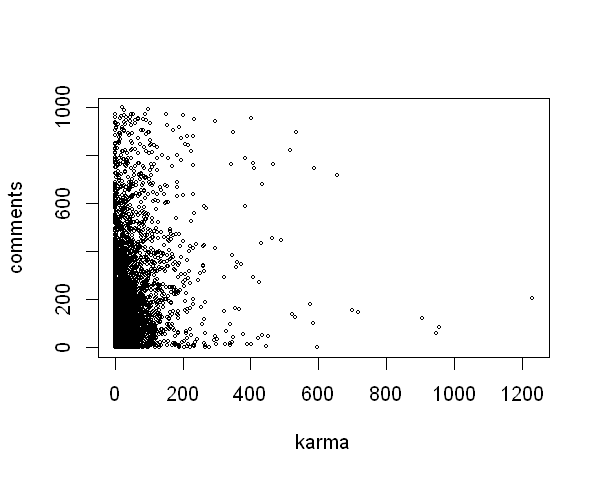

In [3]:
plot(comments ~ karma, data = user_data, cex = 0.5)

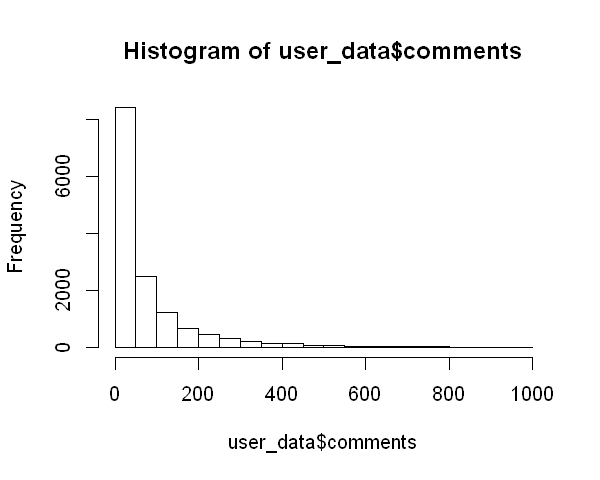

In [4]:
hist(user_data$comments)

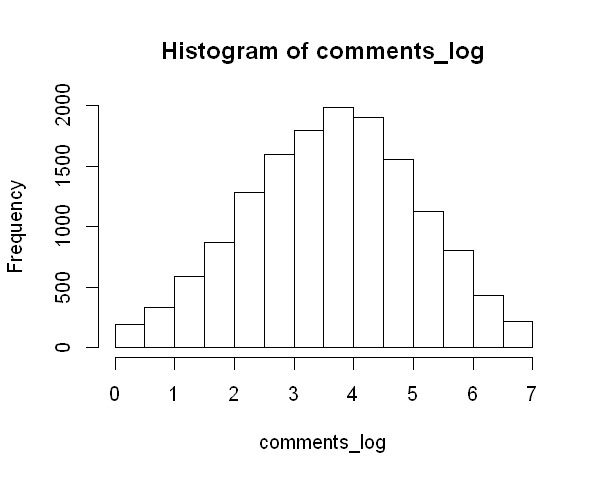

In [5]:
comments_log <- log1p(user_data$comments)
hist(comments_log)

Разбиваем карму на интервалы

In [6]:
karma_cut <- cut(user_data$karma, breaks=c(-Inf, 0, 10, 25, 50, Inf))
table(karma_cut)

karma_cut
 (-Inf,0]    (0,10]   (10,25]   (25,50] (50, Inf] 
     5488      3808      2629      1411      1339 

Ящик с усами

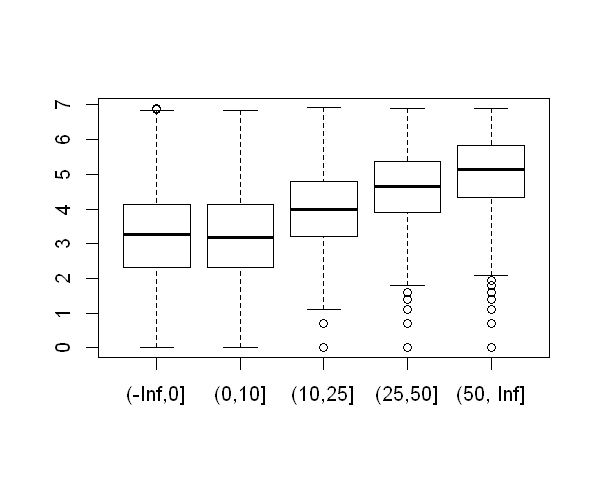

In [7]:
boxplot(comments_log ~ karma_cut)

Проверим нормальность...

In [8]:
shapiro.test(comments_log)

ERROR: Error in shapiro.test(comments_log): sample size must be between 3 and 5000


... но данных слишком много

In [9]:
length(comments_log)

[1] 14675

Возьмем 300 случайных с возвращением

In [10]:
shapiro.test(sample(comments_log, 300, replace = TRUE))


	Shapiro-Wilk normality test

data:  sample(comments_log, 300, replace = TRUE)
W = 0.98818, p-value = 0.01508


На нормальное не похоже, что видно и по QQ plot

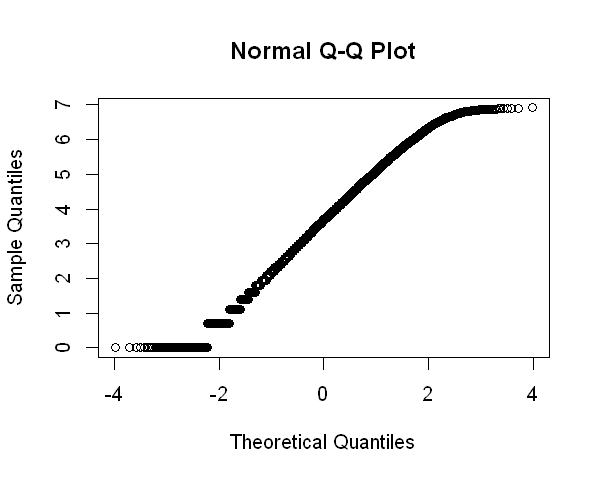

In [11]:
qqnorm(comments_log)

### Далее анализ при неверных предположениях!!! (просто для примера использования функций)

Критерий Бартлетта отвергает гипотезу о равенстве дисперсий в группах

In [12]:
bartlett.test(comments_log ~ karma_cut)


	Bartlett test of homogeneity of variances

data:  comments_log by karma_cut
Bartlett's K-squared = 68.241, df = 4, p-value = 5.336e-14


Однофакторный ANOVA для случая нормальных выборок отвергает гипотезу об отсутствия влияния фактора

In [13]:
m.aov <- aov(comments_log ~ karma_cut)
summary(m.aov)

               Df Sum Sq Mean Sq F value Pr(>F)    
karma_cut       4   5516  1379.0   833.7 <2e-16 ***
Residuals   14670  24264     1.7                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Post hoc анализ методом HSD Тьюки

In [14]:
TukeyHSD(m.aov, "karma_cut", conf.level=0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = comments_log ~ karma_cut)

$karma_cut
                          diff         lwr        upr     p adj
(0,10]-(-Inf,0]    0.009429726 -0.06456789 0.08342734 0.9968708
(10,25]-(-Inf,0]   0.756775337  0.67355669 0.83999398 0.0000000
(25,50]-(-Inf,0]   1.367620300  1.26289594 1.47234466 0.0000000
(50, Inf]-(-Inf,0] 1.742428264  1.63548761 1.84936891 0.0000000
(10,25]-(0,10]     0.747345611  0.65837979 0.83631143 0.0000000
(25,50]-(0,10]     1.358190574  1.24884357 1.46753758 0.0000000
(50, Inf]-(0,10]   1.732998538  1.62152712 1.84446996 0.0000000
(25,50]-(10,25]    0.610844963  0.49505869 0.72663124 0.0000000
(50, Inf]-(10,25]  0.985652927  0.86785831 1.10344755 0.0000000
(50, Inf]-(25,50]  0.374807964  0.24095199 0.50866394 0.0000000


### Далее анализ без использования неверных предположений!!!

Критерий Крускала-Уолиса однофакторного дисперсионного анализа отвергает гипотезу о том, что фактор кармы не влияет на логарифм количества комментариев.

In [15]:
kruskal.test(comments_log ~ karma_cut)


	Kruskal-Wallis rank sum test

data:  comments_log by karma_cut
Kruskal-Wallis chi-squared = 2811.4, df = 4, p-value < 2.2e-16


Post hoc анализ с помощью критерия Данна с поправкой Бонферрони.
Он печатает таблицу попарных сравнений выборок.
В каждой клетке второе число есть pvalue после применения поправки Бонферрони.
Здесь мы видим, что незначимо логарифм количества комментариев отличается только в группах (-Inf,0] vs (0,5] и (50,100] vs (100, Inf].

In [16]:
# install.packages('dunn.test')
library('dunn.test')

dunn.test::dunn.test(comments_log, karma_cut, method = "bonferroni")

  Kruskal-Wallis rank sum test

data: comments_log and karma_cut
Kruskal-Wallis chi-squared = 2811.3516, df = 4, p-value = 0


                    Comparison of comments_log by karma_cut                    
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   (-Inf,0]     (0,10]    (10,25]    (25,50]
---------+--------------------------------------------
  (0,10] |   0.315793
         |     1.0000
         |
 (10,25] |  -22.81451  -21.60336
         |     0.0000     0.0000
         |
 (25,50] |  -33.17260  -31.98393  -13.60598
         |     0.0000     0.0000     0.0000
         |
(50, Inf |  -40.04065  -38.62282  -20.23335  -6.036292
         |     0.0000     0.0000     0.0000     0.0000



То же самое, но с поправкой Холма. Тут незначимое отличие только в группах (50,100] vs (100, Inf].

In [17]:
dunn.test::dunn.test(comments_log, karma_cut, method = "holm")

  Kruskal-Wallis rank sum test

data: comments_log and karma_cut
Kruskal-Wallis chi-squared = 2811.3516, df = 4, p-value = 0


                    Comparison of comments_log by karma_cut                    
                                    (Holm)                                     
Col Mean-|
Row Mean |   (-Inf,0]     (0,10]    (10,25]    (25,50]
---------+--------------------------------------------
  (0,10] |   0.315793
         |     0.3761
         |
 (10,25] |  -22.81451  -21.60336
         |    0.0000*    0.0000*
         |
 (25,50] |  -33.17260  -31.98393  -13.60598
         |    0.0000*    0.0000*    0.0000*
         |
(50, Inf |  -40.04065  -38.62282  -20.23335  -6.036292
         |    0.0000*    0.0000*    0.0000*    0.0000*



---------

Прикладная статистика и анализ данных, 2019

Никита Волков

https://mipt-stats.gitlab.io/